# TFG: Notebook 2: 

Questions to answer:
   - How many images have text?
       - Out of these, how many are blurred?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy  as np
import cv2
import random
import json
import pprint
from collections import Counter

In [2]:
source = '/media/arnau/PEN/TFG/train/'
direc = '../data/'
file = "vizwiz_skill_typ_train.csv"
data = pd.read_csv(direc + file)

## Data cleaning

In [3]:
cleaned_data = data.dropna(axis='columns')
display(cleaned_data.head())
print(f"Dataset size: {cleaned_data.shape}")

,IMG,QSN,TXT,OBJ,COL,CNT,OTH
0,VizWiz_train_00000000.jpg,What's the name of this product?,4,3,0,0,0
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,2,5,1,1,0
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,4,3,1,0,0
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,4,2,1,1,0
4,VizWiz_train_00000004.jpg,What is this item?,3,5,1,0,0


Dataset size: (14239, 7)


In [4]:
interest_col = ["IMG", "QSN", "TXT"]
interest_data = cleaned_data[interest_col]

# Confidence TXT level samples

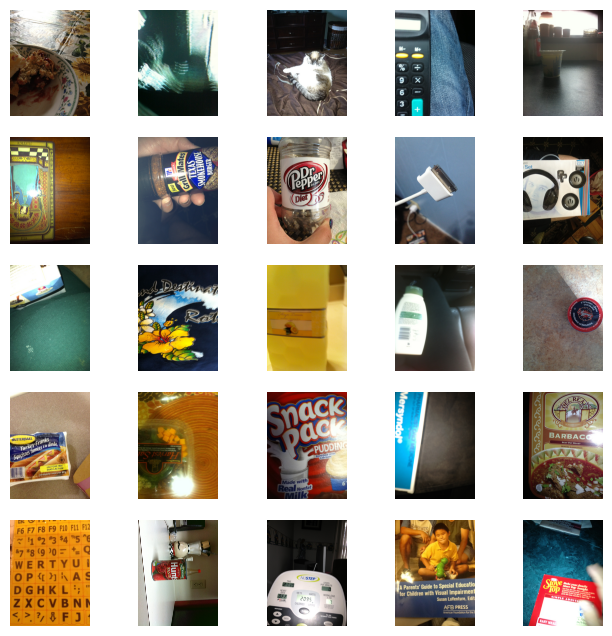

In [5]:
t_imgs = []
seed = 4

for cdf_lvl in range(1, 6):
    cdf = interest_data[interest_data["TXT"] == cdf_lvl]
    random_cdf = cdf.sample(n=5, random_state=seed)
    list_random_cdf_imgs = random_cdf["IMG"].to_list()
    t_imgs.append(list_random_cdf_imgs)
    
all_imgs = [item for sublist in t_imgs for item in sublist]

nrow, ncol = 5, 5
_, axs = plt.subplots(nrow, ncol, figsize=(8, 8))
axs = axs.flatten()
for img, ax in zip(all_imgs, axs):
    img = cv2.imread(source + img)
    imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(imgc)
    ax.axis('off')
plt.show()

## How many images have text?
We find the images in the dataset that have **more than 3 votes**, those will be the ones that contain text

In [6]:
df_w_3vts = interest_data[interest_data["TXT"] >= 3]
imgs_w_txt = df_w_3vts["IMG"].to_list()
n_imgs_w_txt = df_w_3vts.shape[0]
total_percent_img_w_txt = (n_imgs_w_txt / interest_data.shape[0]) * 100
print(f"{n_imgs_w_txt}/{interest_data.shape[0]} = {round(total_percent_img_w_txt, 2)}%")

6410/14239 = 45.02%


### Blurred
Out of the images containing text, find how many of those are blurried

<u>**2 approaches:**</u>

#### Automatic approach
Given a threshold, find which images are blurried using OpenCV

In [7]:
def blur_detector(img_path, thr=100):
    image = cv2.imread(img_path)
    b = cv2.Laplacian(image, cv2.CV_64F).var()
    if b <= thr: return img_path

**Testing threshold manually**

In [ ]:
t_thr = []

for img in imgs_w_txt:
    blrd_img = blur_detector(source + img, thr=70)
    if blrd_img:
        t_thr.append(blrd_img)


In [ ]:
r = random.randint(0, len(t_thr))
random_img = t_thr[r]
plt.figure(figsize=(4, 4))
img = cv2.imread(random_img)

plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
blurred_imgs_labels = []

# For every img contaning text, check if it's blurred, if so append to list
for img in imgs_w_txt:
    blrd_img = blur_detector(source + img)
    if blrd_img:
        blurred_imgs_labels.append(blrd_img)
        
p_imtg_blrd = round((len(blurred_imgs_labels) / len(imgs_w_txt)) * 100, 2)

print(f"{len(blurred_imgs_labels)} images blurred out of {len(imgs_w_txt)} ≈ {p_imtg_blrd}%")

#### Dataset Assessing approach
Framing : FRM --- Blurried : BLR --- Dark : DRK --- Bright : BRT ---
Obstructed : OBS --- Other : OTH --- NoFlaws : NON --- Rotated : ROT


In [7]:
train_json_qlty = '/media/arnau/PEN/TFG/data_assesing/'

with open(train_json_qlty + "final.json", encoding='UTF-8') as json_file:
    data = json.load(json_file)
    data = data["train"]
    # {img_name : {info_img ...}}
    
    
data_size = len(data)
print(f"Dataset size: {data_size}")

Dataset size: 20000


In [8]:
# Sample a data item
key = list(data.keys())[0]
value = list(data.values())[0]
print(f"{key}\n")
pprint.pprint(value)

VizWiz_train_00000000.jpg

{'answerable': 1.0,
 'flaws': [True, False, False, False, False, False, False, False],
 'question': "What's the name of this product?",
 'recognizable': 1.0}


In [9]:
list_imgs_dts1 = interest_data["IMG"].to_list()
list_imgs_dts2 = list(data.keys())

print(f"Number of imgs: \n\t dataset1: {len(list_imgs_dts1)} \n\t dataset2: {len(list_imgs_dts2)}")

Number of imgs: 
	 dataset1: 14239 
	 dataset2: 20000


In [10]:
# From the 1st dataset, array containing all images with text
arr_imgs_w_txt = np.array(imgs_w_txt, dtype=str)

# From the 2nd dataset, array containing all images
arr_imgs_dts2 = np.array(list_imgs_dts2, dtype=str)

# Images present in both datasets
common_imgs = list(set(list_imgs_dts1).intersection(list_imgs_dts2))
print(f"Intersection dataset size: {len(common_imgs)} imgs")

Intersection dataset size: 14228 imgs


In [11]:
# How many imgs from the 1st dataset (txt) are also in the 2nd one?
total_imgs_w_txt = np.array(list(set(arr_imgs_w_txt).intersection(common_imgs)), 
                          dtype=str)

In [19]:
# Save json file with all images containing text
names_imgs_w_txt = list(set(arr_imgs_w_txt).intersection(common_imgs))
json_imgs_w_txt = {img: data[img] for img in names_imgs_w_txt}

with open('../data/imgs_w_txt.json', 'w') as outfile:
    json.dump(json_imgs_w_txt, outfile)

How many images in the dataset contain text?

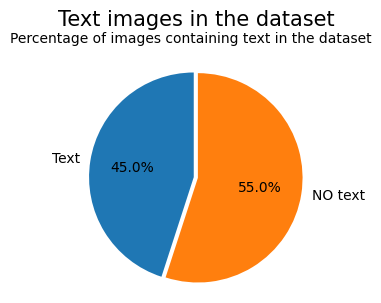

In [20]:
labels = 'Text', 'NO text'
n_imgs_w_text = total_imgs_w_txt.shape[0]
n_imgs_wo_text = len(common_imgs) - n_imgs_w_text
sizes = [n_imgs_w_text, n_imgs_wo_text]
explode = (0.04, 0)  # for highligthing

fig1, ax1 = plt.subplots(figsize=(4, 3))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal') 
fig1.suptitle(f"Percentage of images containing text in the dataset",fontsize=10)
ax1.set_title(f"Text images in the dataset\n", y=1.02, fontsize=15)
plt.show()

In [ ]:
def get_flaw(info_img, flaw):
    """
    For a given flaw, checks if it is present in the image
    """
    
    flaws = {'FRM': 0, 'BLR': 1, 'DRK': 2, 'BRT': 3, 
                  'OBS': 4, 'OTH': 5, 'NON': 6, 'ROT': 7}
    idx = flaws[flaw]
    
    return True if info_img["flaws"][idx] == True else False

In [ ]:
flaw_typed_imgs = []
flaw = "BLR"

# Return a list with the images that have the given flaw
for img in total_imgs_w_txt:
    info_img = data[img] # dict with img flaws
    if not get_flaw(info_img, "NON"): # if the img is flawed
        answerable = True if info_img["answerable"] == 1.0 else False
        recognizable = True if info_img["recognizable"] == 1.0 else False

        flawed = get_flaw(info_img, flaw) # Specify the desired flaw 

        if answerable and recognizable and flawed:
            flaw_typed_imgs.append(img)

In [ ]:
print(f"\nImages containing text and {flaw}\n")
nrow, ncol = 4, 4
_, axs = plt.subplots(nrow, ncol, figsize=(8, 8))
axs = axs.flatten()
random.shuffle(flaw_typed_imgs)
for img, ax in zip(flaw_typed_imgs, axs):
    img = cv2.imread(source + img)
    imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(imgc)
    ax.axis('off')
plt.show()

In [ ]:
# Stats
n_flaw_typed_imgs = len(flaw_typed_imgs)

In [ ]:
labels = f'{flaw}', 'Other flaws'
other_flaws = len(total_imgs_w_txt) - n_flaw_typed_imgs
sizes = [n_flaw_typed_imgs, other_flaws]
explode = (0.04, 0)  # for highligthing

fig1, ax1 = plt.subplots(figsize=(4, 3))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal') 
fig1.suptitle(f"How many text-{flaw} images are there?",fontsize=10)
ax1.set_title(f"{flaw} frequency of images containing text\n", y=1.02, fontsize=15)
plt.show()

#### Frequency of flaws of all images containing text

In [ ]:
flaws = {'FRM': 0, 'BLR': 0, 'DRK': 0, 'BRT': 0, 
        'OBS': 0, 'OTH': 0, 'ROT': 0, 'NON': 0}

for i, img in enumerate(total_imgs_w_txt):
    info_img = data[img] # dict with img flaws
    for flaw in flaws.keys():
        if get_flaw(info_img, flaw) and flaw != "NON": # only flawed imgs
            flaws[flaw] += 1
            
flaws = {flaw : freq for flaw, freq in sorted(flaws.items(),
                                              key=lambda item : item[1],
                                          reverse=True)}


In [ ]:
# TODO: Add axes and title

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])

x_flaws = list(flaws.keys())
y_freq = list(flaws.values())

ax.bar(x_flaws,y_freq)
ax.set_xlabel("Flaw")
ax.set_ylabel("Number of images")
ax.set_title("Frequency of flaws of all images containing text")
plt.show()